**Zero Sum - Pure Strategies**

In [8]:
import numpy as np

def zerosum_pure(M):
    M = np.array(M)

    row_min = M.min(axis=1)
    v_under = row_min.max()
    istar = np.argmax(row_min)

    col_max = M.max(axis=0)
    v_over = col_max.min()
    jstar = np.argmin(col_max)

    return istar, jstar, v_under, v_over

M = [[1, 3],
     [4, 2]]

istar, jstar, v_under, v_over = zerosum_pure(M)

print(f"Row Security Strategy (istar): {istar+1}")
print(f"Column Security Strategy (jstar): {jstar+1}")
print(f"Row Security Level (v_under): {v_under}")
print(f"Column Security Level (v_over): {v_over}")


Row Security Strategy (istar): 2
Column Security Strategy (jstar): 2
Row Security Level (v_under): 2
Column Security Level (v_over): 3


**Zero Sum - Mixed Strategies**

In [9]:
import numpy as np
from scipy.optimize import linprog

def zerosummixed(M):
    m, n = M.shape

    c_row = np.zeros(m + 1)
    c_row[-1] = -1

    A_row = np.column_stack([-M.T, np.ones((n, 1))])
    b_row = np.zeros(n)

    A_eq_row = np.zeros((1, m + 1))
    A_eq_row[0, :-1] = 1
    b_eq_row = np.array([1])

    bounds_row = [(0, 1) for _ in range(m)] + [(None, None)]

    res_row = linprog(c_row, A_ub=A_row, b_ub=b_row,
                      A_eq=A_eq_row, b_eq=b_eq_row,
                      bounds=bounds_row, method='highs')

    if not res_row.success:
        raise ValueError('No solution found for row player')

    pstar = res_row.x[:-1]
    val = -res_row.fun


    c_col = np.zeros(n + 1)
    c_col[-1] = 1

    A_col = np.column_stack([M, -np.ones((m, 1))])
    b_col = np.zeros(m)


    A_eq_col = np.zeros((1, n + 1))
    A_eq_col[0, :-1] = 1
    b_eq_col = np.array([1])


    bounds_col = [(0, 1) for _ in range(n)] + [(None, None)]


    res_col = linprog(c_col, A_ub=A_col, b_ub=b_col,
                      A_eq=A_eq_col, b_eq=b_eq_col,
                      bounds=bounds_col, method='highs')

    if not res_col.success:
        raise ValueError('No solution found for column player')

    qstar = res_col.x[:-1]

    return pstar, qstar, val


if __name__ == "__main__":
    M = np.array([[1, 3],
                  [4, 2]])

    try:
        pstar, qstar, val = zerosummixed(M)
        print("\nResults:")
        print("Row player optimal strategy p*: ", pstar)
        print("Column player optimal strategy q*: ", qstar)
        print("Game value:", val)

        # Verify the solution
        print("\nVerification:")
        print("Expected payoff:", pstar @ M @ qstar)

    except ValueError as e:
        print("Error:", str(e))


Results:
Row player optimal strategy p*:  [0.5 0.5]
Column player optimal strategy q*:  [0.25 0.75]
Game value: 2.5

Verification:
Expected payoff: 2.5


**2 Player Fictitious**

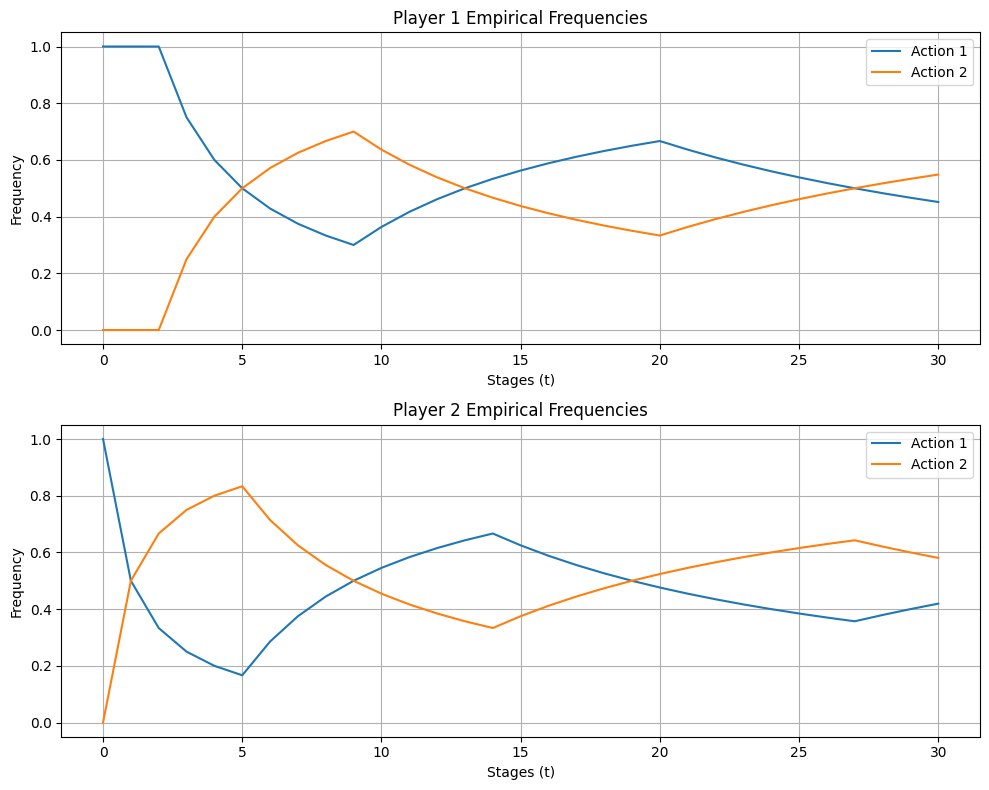

In [11]:
import numpy as np
import matplotlib.pyplot as plt

def FPdynamics(M1, M2, T):
    m, n = M1.shape

    B1 = np.zeros((m, T+1))
    B2 = np.zeros((n, T+1))

    action1 = np.random.randint(0, m)
    action2 = np.random.randint(0, n)

    count1 = np.zeros(m)
    count2 = np.zeros(n)
    count1[action1] = 1
    count2[action2] = 1

    B1[:, 0] = count1 / 1
    B2[:, 0] = count2 / 1

    for t in range(T):
        freq1 = count1 / (t + 1)
        freq2 = count2 / (t + 1)

        payoff1 = M1 @ freq2
        payoff2 = M2.T @ freq1

        action1 = np.argmax(payoff1)
        action2 = np.argmax(payoff2)


        count1[action1] += 1
        count2[action2] += 1

        B1[:, t+1] = count1 / (t + 2)
        B2[:, t+1] = count2 / (t + 2)


    plt.figure(figsize=(10, 8))

    plt.subplot(2, 1, 1)
    for i in range(m):
        plt.plot(range(T+1), B1[i, :], linewidth=1.5, label=f'Action {i+1}')
    plt.title('Player 1 Empirical Frequencies')
    plt.xlabel('Stages (t)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)

    plt.subplot(2, 1, 2)
    for i in range(n):
        plt.plot(range(T+1), B2[i, :], linewidth=1.5, label=f'Action {i+1}')
    plt.title('Player 2 Empirical Frequencies')
    plt.xlabel('Stages (t)')
    plt.ylabel('Frequency')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()

    return B1, B2

if __name__ == "__main__":
    M1 = np.array([[1, -1],
                   [-1, 1]])
    M2 = -M1
    B1, B2 = FPdynamics(M1, M2, 30)